# Initialization and helper functions
As always the MiniSim libraries need to be loaded into Python. As they are .net libraries, we need the pythonnet package and the clr module.

In [1]:
import clr
clr.AddReference(r"..\..\bin\MiniSim.Core")
clr.AddReference(r"..\..\bin\MiniSim.FlowsheetDrawing")

import MiniSim.Core.Expressions as expr
from  MiniSim.Core.Flowsheeting import MaterialStream, Flowsheet,IconTypes,PortNormal
from  MiniSim.Core.Flowsheeting.Documentation import SpreadsheetElement
import MiniSim.Core.Numerics as num
from MiniSim.Core.UnitsOfMeasure import Unit, SI, METRIC, PhysicalDimension
from MiniSim.Core.ModelLibrary import Flash, Heater, Mixer, Splitter, EquilibriumStageSection,Source,Sink
import MiniSim.Core.PropertyDatabase as chemsep
from MiniSim.Core.Reporting import Generator, StringBuilderLogger
from MiniSim.Core.Thermodynamics import ThermodynamicSystem
from MiniSim.FlowsheetDrawing import FlowsheetDrawer, DrawingOptions

We need access to the ChemSep database for the example process and we create instances of the logger and reporter class.

In [2]:
Database = chemsep.ChemSepAdapter()
logger = StringBuilderLogger();
reporter = Generator(logger)

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx  
from IPython.display import Image as render
plt.rcParams["figure.figsize"] = (16,8)
plt.rcParams['grid.color'] = 'k'

These functions just encapsulate some commonly used functionality. With calc() we can solve a flowsheet using the basic Newton solver, whereas with solve() we use the Decomposition solver.

ConvertFlowsheet() renders a logical flowsheet into an image and converts the image into base64 encoding.

In [4]:
def calc(flowsheet, relax, maxIter):
    presolver=  num.BasicNewtonSolver(logger)
    presolver.MaximumIterations=maxIter
    presolver.BrakeFactor=relax
    presolver.Solve(flowsheet)
    print (logger.Flush())
    
def solve(flowsheet):
    solver= num.DecompositionSolver(logger)
    solver.Solve(flowsheet)
    print (logger.Flush())
    
def convertFlowsheet(flowsheet, options=None):
    drawer= FlowsheetDrawer()
    if(options!=None):
        drawer.Options=options
    return bytes(drawer.DrawAsBase64(flowsheet)) 
def report(item):
    reporter.Report(item)
    print(logger.Flush())
    return

Here we create the property system for the case study. We use a basic NRTL approach for modeling the non-ideality of the liquid phase. In this case we take the Benzene/Toluene/Xylene ternary system, but the method should be general, so we rename the component to A,B and C respectively. This way, we can refer to the generalized components in the modeling step, and later change the thermodynamic property system to any other zeotropic system.

In [5]:
sys= ThermodynamicSystem("Test2","NRTL", "default")
sys.AddComponent(Database.FindComponent("Benzene").RenameID("A"))
sys.AddComponent(Database.FindComponent("Toluene").RenameID("B"))
sys.AddComponent(Database.FindComponent("P-xylene").RenameID("C"))
Database.FillBIPs(sys)

Because pythonnet does not support operator overloading we need to use the Make() helper function to create our composite units of measure. If we used C# as a hosting language, we could have written SI.kmol/SI.h and relied on the overloaded operators defined in the Unit class.

In [6]:
kmolh=Unit.Make([SI.kmol],[SI.h])
tonh=Unit.Make([METRIC.ton],[SI.h])

# The Genotype model
At this point we are ready to start our modeling endeavor. To test out the idea of a generic process model that is later translated into a "real" flowsheet, we start with a very simple Python dictionary.

The genotype consists of
* A counter for the generation
* An ID to identify the individual within the generation
* A list of UnitGenes
* A list of StreamGenes

The UnitGene consists of a class identifier that is used to create UnitOperation instances later, as well as the parameters needed to make the model specification square. We will rely only on the evolutionary search to optimize our process and thus have to make sure that the flowsheet is fully specified.

Each unit will have a field called IsMandatory, to tell the mutation operator that such a unit MUST exist in a flowsheet and cannot be removed by mutation. This is neccessary to guarantee that we will always have a feed. This feature is also described in the paper of [Leveux](https://www.sciencedirect.com/science/article/pii/S0009250918302136).

The MaterialStream meta-model is very simple and will only consist of a name for the stream, the source unit and port, and the sink unit and port. At this point in the development we will not support any specifications in the streams and handle those only on the objective function level.

For the start I will model a small flowsheet consisting of two flashes and a condenser to test out the idea.

In [7]:
genotype={
    "Generation":1,
    "ID":1,
    "UnitGenes":[
        {
            "ID":"U1",
            "Class":"Feed",
            "IsMandatory":True,
            "Parameters":[ 
                {"Name":"n","Value":100,"UoM": kmolh},
                {"Name":"T","Value":298,"UoM": SI.K},
                {"Name":"P","Value":370,"UoM": METRIC.mbar},
                {"Name":"x[A]","Value":0.3,"UoM": SI.none},
                {"Name":"x[B]","Value":0.3,"UoM": SI.none},
                {"Name":"x[C]","Value":0.4,"UoM": SI.none},
            ]
        },
         {
            "ID":"U2",
            "Class":"Flash",
             "IsMandatory":False,
             "Parameters":[
                {"Name":"VF","Value":0.5,"Min":0.2,"Max":0.8,"UoM": SI.none},
                {"Name":"P","Value":370,"UoM": METRIC.mbar},
             ]                       
        },
         {
            "ID":"U3",
            "Class":"Product",
             "IsMandatory":False,
             "Parameters":[]                       
        }
        ,
         {
            "ID":"U4",
            "Class":"Product",
             "IsMandatory":False,
             "Parameters":[]                       
        },
         {
            "ID":"U5",
            "Class":"Flash",
             "IsMandatory":False,
             "Parameters":[
                {"Name":"VF","Value":0.5,"Min":0.2,"Max":0.8,"UoM": SI.none},
                {"Name":"P","Value":370,"UoM": METRIC.mbar},
             ]                       
        },
         {
            "ID":"U6",
            "Class":"Heater",
             "IsMandatory":False,
             "Parameters":[
                {"Name":"VF","Value":0,"UoM": SI.none},
                {"Name":"P","Value":370,"UoM": METRIC.mbar},
             ]                       
        },
        {
            "ID":"U7",
            "Class":"Product",
             "IsMandatory":False,
             "Parameters":[]                       
        },
    ],
    "StreamGenes":[
        {"ID":"S1", "From":("U1","Out"), "To":("U2","In")},
        {"ID":"S2", "From":("U2","Vap"), "To":("U6","In")},
        {"ID":"S3", "From":("U2","Liq"), "To":("U5","In")},
        {"ID":"S4", "From":("U5","Vap"), "To":("U3","In")},
        {"ID":"S5", "From":("U5","Liq"), "To":("U4","In")},
        {"ID":"S6", "From":("U6","Out"), "To":("U7","In")},
    ]
}
genotype

{'Generation': 1,
 'ID': 1,
 'UnitGenes': [{'ID': 'U1',
   'Class': 'Feed',
   'IsMandatory': True,
   'Parameters': [{'Name': 'n',
     'Value': 100,
     'UoM': <MiniSim.Core.UnitsOfMeasure.Unit at 0x1adea76b488>},
    {'Name': 'T',
     'Value': 298,
     'UoM': <MiniSim.Core.UnitsOfMeasure.Unit at 0x1adea77d548>},
    {'Name': 'P',
     'Value': 370,
     'UoM': <MiniSim.Core.UnitsOfMeasure.Unit at 0x1adea77d6c8>},
    {'Name': 'x[A]',
     'Value': 0.3,
     'UoM': <MiniSim.Core.UnitsOfMeasure.Unit at 0x1adea77d708>},
    {'Name': 'x[B]',
     'Value': 0.3,
     'UoM': <MiniSim.Core.UnitsOfMeasure.Unit at 0x1adea77d748>},
    {'Name': 'x[C]',
     'Value': 0.4,
     'UoM': <MiniSim.Core.UnitsOfMeasure.Unit at 0x1adea77d788>}]},
  {'ID': 'U2',
   'Class': 'Flash',
   'IsMandatory': False,
   'Parameters': [{'Name': 'VF',
     'Value': 0.5,
     'Min': 0.2,
     'Max': 0.8,
     'UoM': <MiniSim.Core.UnitsOfMeasure.Unit at 0x1adea77d7c8>},
    {'Name': 'P',
     'Value': 370,
     'U

Now that we have a genotype model, we need to project this abstract data model into an instance of the flowsheet class, i.e. an object that reflects the behaviour of the flowsheet and can be used for evaluating the design. 

The Genotype2Phenotype function is a simple Factory Method that creates a new instance of the Flowsheet class and then iterates over the UnitGenes in the genotype to add UnitOperations to the flowsheet. We just assume that the parameters used in the genotype also exist in the respective UnitOperation, a fact we need to consider later when we create the Mutation Operator.


Once all the units are instantiated and added to the flowsheet, we iterate over the MaterialStream genes and connect the units.

In [8]:
def Genotype2Phenotype(genotype):
    flowsheet= Flowsheet(f"Individual_Gen{genotype['Generation']}:{genotype['ID']}")
    for u in genotype['UnitGenes']:
        unit=None
        if u['Class']=="Flash":
            unit= Flash(u['ID'],sys)           
            for p in u['Parameters']:         
                unit.Specify(p['Name'],p['Value'], p['UoM'])            
            flowsheet.AddUnit(unit)
        if u['Class']=="Heater":
            unit= Heater(u['ID'],sys)           
            for p in u['Parameters']:         
                unit.Specify(p['Name'],p['Value'], p['UoM'])            
            flowsheet.AddUnit(unit)            
        if u['Class']=="Feed":
            unit= Source(u['ID'],sys)           
            for p in u['Parameters']:         
                unit.Specify(p['Name'],p['Value'], p['UoM'])    
            flowsheet.AddUnit(unit)
        if u['Class']=="Product":
            unit= Sink(u['ID'],sys)                          
            flowsheet.AddUnit(unit)
    for s in genotype['StreamGenes']:                      
        stream=MaterialStream(s['ID'],sys)
        flowsheet.AddMaterialStream(stream)        
        flowsheet.GetUnit(s['From'][0]).Connect(s['From'][1],stream)
        flowsheet.GetUnit(s['To'][0]).Connect(s['To'][1],stream)
    return flowsheet

In [9]:
phenotype=Genotype2Phenotype(genotype)

Now that we have a phenotype, which is just a normal MiniSim flowsheet, we need a method to evaluate the design. For this, we need to solve the entire flowsheet! This is no easy task, especially since we only have a simultaneous solver at our disposal. 

For now, I will trick and use the trivial initialze() method, which will just solve each unit in the sequence in which they were added to the flowsheet. For our hand-crafted example, this will suffice, as the flowsheet has no recycles and I added the flashes in the correct order, so each unit has valid starting conditions.

As the models in MiniSim are purely phenomenological units, it is not possible to create an economic cost function yet. I will use a simple surrogate instead, which will drive the optimization to create a flowsheet that will separate the three components into pure streams. We just iterate over all Sink units, and look for the maximum molar composition for each component and add them together. In theory, the best flowsheet would have an objective function value of ~3, or 0.99999.. molar purity for each substance.

In [10]:
def EvaluatePhenotype(phenotype):
    f=-1e20
    phenotype.Initialize()
    solve(phenotype)
    #report(phenotype)
    puritiesA=[]
    puritiesB=[]
    puritiesC=[]
    for u in phenotype.Units:
        if(u.Class=="Sink"):
            s=u.FindMaterialPort("In").Streams[0]
            puritiesA.append(s.GetVariable('x[A]').DisplayValue)
            puritiesB.append(s.GetVariable('x[B]').DisplayValue)
            puritiesC.append(s.GetVariable('x[C]').DisplayValue)    
    f=max(puritiesA)+max(puritiesB)+max(puritiesC)
    return f

Our simple flowsheet has an objective function value of 1.46. There is definetely room for improvement, which we will explore in the rest of the article series.

To prove that the model was really solved lets print the stream table and look at the resulting values. Each flash separates the inlet stream with a 50:50 split of vapour/liquid.

In [11]:
EvaluatePhenotype(phenotype)

Decomposition Result: V=290, E=290, Blocks=236, Singletons=227
Block Statistics:
   # Var # Blocks % Blocks
       1      227  96,19 %
       7        9   3,81 %
Problem Individual_Gen1:1 was successfully solved (0,049 seconds)



1.4647265937571388

In [12]:
reporter.Report(phenotype, 3, False)
print(logger.Flush())


Report for flowsheet Individual_Gen1:1

Material Streams

System                    Test2      

Property                  Unit                 S1           S2           S3

Temperature               °C              24.8500      81.3789      81.3789
Pressure                  mbar           370.0000     370.0000     370.0000
Vapor Fraction            mol/mol          0.0000       1.0000       0.0000
Specific Enthalpy         kJ/kmol     -38507.2235    6173.2962  -29671.5835
Phase                                      Liquid  LiquidVapor       Liquid
Density                   kmol/cum         9.2273       0.0126       8.2861
Mass Density              kg/cum         863.1348       1.1226     809.1230
Volume Flow               cum/h           10.8374    3983.4015       6.0342
Molar Weight              kg/kmol         93.5411      89.4336      97.6485

Total Molar Flow          kmol/h         100.0000      50.0000      50.0000
                        A kmol/h          30.0000      22.0741  

While it is nice to see that the model did indeed solve, we might want to have a more direct way to check the results of our algorithm. Luckily, the FlowsheetDrawing module of MiniSim provides facilities to render a flowsheet. We just need to manually edit the positions of the flowsheet icons. I do not know of ANY published graph layouting algorithm that gives acceptable results for process flowsheets, so we have to hack our own.

In the trivial algorithm below, we iterate recursively over all the nodes (starting from source streams) and assign x and y locations according to two simple rules.

* If the outlet port has a vertical component add or subtract 100 from the y position.
* Add 160 to the x position for each "layer" in the flowsheet.

In the end, loop over all the units and if the smallest y position is negative, add this value to all y positions to shift the flowsheet into the visible area again.

In [13]:
def updatePosition(unit, x,y,visitedNodes):
    
    if(unit in visitedNodes):
        return 
    
    if(unit.Class=="Source" or unit.Class=="Sink"):
        unit.SetIcon(IconTypes.Stream, x,y)
    if(unit.Class=="Flash"):
        unit.SetIcon(IconTypes.TwoPhaseFlash, x,y)
    if(unit.Class=="Heater"):
        unit.SetIcon(IconTypes.Heater, x,y)
    
    visitedNodes.append(unit)
    
    for i,port in enumerate(unit.GetMaterialOutPorts()):
        suc= port.Streams[0].Sink
        
        if(suc):
            dy=0
            if(port.Normal==PortNormal.Up):
                dy=-100
            if(port.Normal==PortNormal.Down):
                dy=+100                
            updatePosition(suc, x+160, y+dy,visitedNodes)
    return
    
def AutomaticLayout(phenotype):
    x=60
    y=0
    visitedNodes=[]
    sources= phenotype.GetUnitsByModelClass("Source")
    for s in sources:
        updatePosition(s, x,y,visitedNodes)
        y+=300
    
    for u in phenotype.Units:
        if(u.Icon.Y<y):
            y=u.Icon.Y
    
    if(y<0):
        y=abs(y)
    else:
        y=0
        
    for u in phenotype.Units:        
            u.Icon.Y+=y+50
    
    return
            
        

In [14]:
AutomaticLayout(phenotype)

After we have applied the layouting algorithm we can use the convertFlowsheet helper method to show it in our Jupyter notebook. It will surely wont will any prices for beauty, but it will suffice for now. There are some problems with the algorithm, as layered tree structures of separators will lead to overlaps (as the height of each branch is not back-propagated to the beginning yet) for example. But for now, we can use it to get an idea what our phenotype really looks like.

We can see that the mass flows are not split 50/50, because the vapor fraction is specified on a molar basis. We can see the bubble and dew point temperatures of the mixtures at the corresponding concentrations, and we can see that the condenser cooled down stream S6 to the bubble point.

Dotted lines indicate vapor flows, so indeed the flashes work as intended and produce a vapor/liquid split.

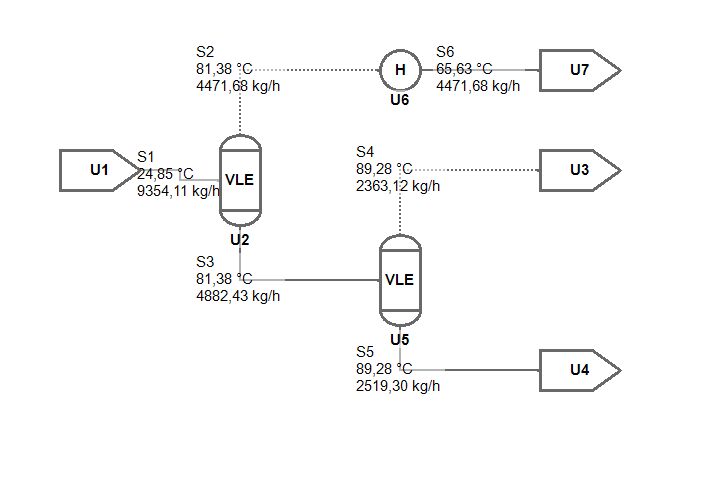

In [15]:
options=DrawingOptions()
options.ShowStreamWidth=False
options.ShowPressure=False
options.ShowMassFlow=True
options.ShowTemperature=True
options.ShowStreamColors=False
render(convertFlowsheet(phenotype,options))